<a href="https://colab.research.google.com/github/LEEINSEO-0118/Artist_Classification/blob/main/CV_Project_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn

import torchvision
from torchvision.io import read_image
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.utils import draw_bounding_boxes
from torchvision import transforms

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.auto import tqdm

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## Hyper Paramerters

In [5]:
CFG = {
    'num_class':50,
    'img_size':224,
    'epochs':10,
    'lr': 1e-4,
    'batch_size':64,
    'seed' : 41
}

## RandomSeed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['seed']) # Seed 고정

## Show Image and EDA

In [7]:
file_path = '/content/drive/MyDrive/ai부트캠프/CV_Project/Data/'

In [8]:
train = pd.read_csv(file_path + 'train.csv')
train.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [9]:
test = pd.read_csv(file_path + 'test.csv')
test.head()

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


h: 836, w: 1053, c: 3


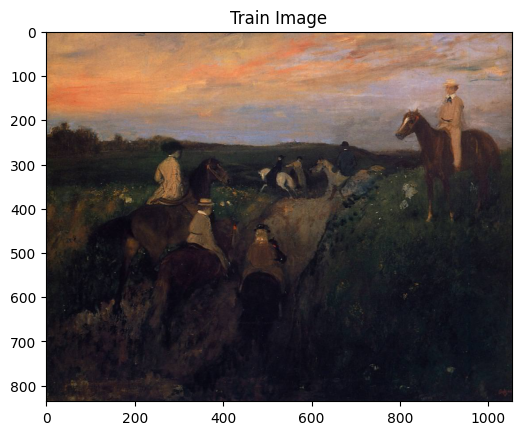

In [10]:
image = cv2.imread(file_path + './train/0003.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
size = image.shape
print(f'h: {size[0]}, w: {size[1]}, c: {size[2]}')
plt.imshow(image)
plt.title('Train Image')
plt.show()

h: 387, w: 512, c: 3


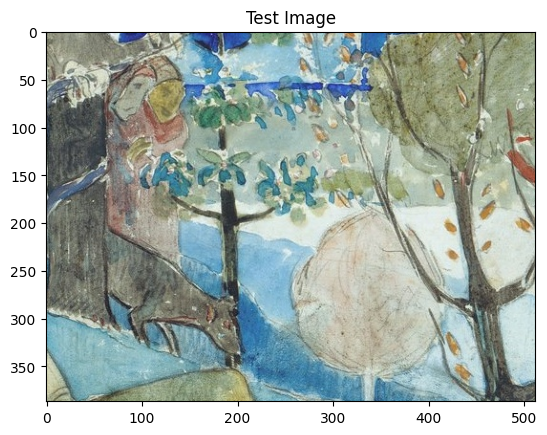

In [11]:
image = cv2.imread(file_path + './test/TEST_00010.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
size = image.shape
print(f'h: {size[0]}, w: {size[1]}, c: {size[2]}')
plt.imshow(image)
plt.title('Test Image')
plt.show()

명화의 특성상 이미지의 크기가 다양하다.  
Test의 경우 이미지를 1/4한 것이기 때문에 그것 보다 작은 경우가 꽤 있을 것 같음.

In [12]:
print(f'Train Images : {len(train)}')
print(f'Test Images : {len(test)}')
print(f'Artists Count : {len(train.artist.unique())}')

Train Images : 5911
Test Images : 12670
Artists Count : 50


In [13]:
train.artist.value_counts().index

Index(['Vincent van Gogh', 'Edgar Degas', 'Pablo Picasso',
       'Pierre-Auguste Renoir', 'Albrecht Du rer', 'Paul Gauguin',
       'Francisco Goya', 'Rembrandt', 'Titian', 'Marc Chagall',
       'Alfred Sisley', 'Paul Klee', 'Rene Magritte', 'Amedeo Modigliani',
       'Andy Warhol', 'Henri Matisse', 'Sandro Botticelli', 'Mikhail Vrubel',
       'Hieronymus Bosch', 'Leonardo da Vinci', 'Salvador Dali',
       'Peter Paul Rubens', 'Kazimir Malevich', 'Pieter Bruegel',
       'Frida Kahlo', 'Diego Velazquez', 'Joan Miro', 'Andrei Rublev',
       'Raphael', 'Giotto di Bondone', 'Gustav Klimt', 'El Greco',
       'Camille Pissarro', 'Jan van Eyck', 'Edouard Manet',
       'Henri de Toulouse-Lautrec', 'Vasiliy Kandinskiy', 'Piet Mondrian',
       'Claude Monet', 'Henri Rousseau', 'Diego Rivera', 'Edvard Munch',
       'William Turner', 'Gustave Courbet', 'Michelangelo', 'Paul Cezanne',
       'Caravaggio', 'Georges Seurat', 'Eugene Delacroix', 'Jackson Pollock'],
      dtype='object')

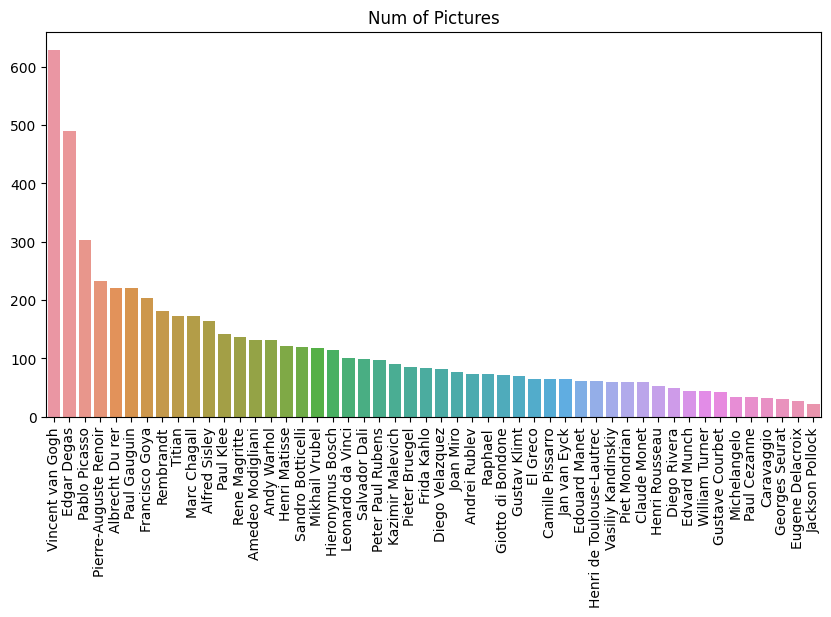

In [14]:
plt.figure(figsize = (10, 5))
sns.barplot(x = train.artist.value_counts().index,
            y = train.artist.value_counts().values)
plt.xticks(rotation=90)
plt.title('Num of Pictures')
plt.show()

특정 화가들에게 데이터가 쏠리는 현상 --> Class Imbalacne

In [15]:
artist_info = pd.read_csv(file_path + 'artists_info.csv')
artist_info.head()

,name,years,genre,nationality
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican
3,Claude Monet,1840 - 1926,Impressionism,French
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian


## Agumentation

In [17]:
class_list = ['Diego Velazquez', 'Vincent van Gogh', 'Claude Monet',
       'Edgar Degas', 'Hieronymus Bosch', 'Pierre-Auguste Renoir',
       'Rene Magritte', 'Michelangelo', 'Peter Paul Rubens', 'Caravaggio',
       'Alfred Sisley', 'Edouard Manet', 'Rembrandt', 'Francisco Goya',
       'Pablo Picasso', 'Titian', 'Mikhail Vrubel', 'Leonardo da Vinci',
       'Kazimir Malevich', 'Andy Warhol', 'Vasiliy Kandinskiy',
       'Gustav Klimt', 'Amedeo Modigliani', 'Henri Rousseau',
       'Salvador Dali', 'Pieter Bruegel', 'Albrecht Du rer',
       'Paul Gauguin', 'Sandro Botticelli', 'Piet Mondrian',
       'Eugene Delacroix', 'Paul Klee', 'William Turner', 'Marc Chagall',
       'Jan van Eyck', 'Henri Matisse', 'El Greco', 'Gustave Courbet',
       'Andrei Rublev', 'Jackson Pollock', 'Edvard Munch',
       'Camille Pissarro', 'Raphael', 'Henri de Toulouse-Lautrec',
       'Joan Miro', 'Giotto di Bondone', 'Diego Rivera', 'Frida Kahlo',
       'Georges Seurat', 'Paul Cezanne']

In [22]:
class DataSet(Dataset):
    def __init__(self, root, data, train = True, transform = None):
        self.root = root
        self.data = data
        self.train = train
        self.transform = transform
        if self.train:
            self.imgs = data.img_path.values
            self.labels = data.artist.values
        else:
            self.imgs = data.img_path.values

    def __len__(self):
        return len(self.imgs) # train or test 이미지 데이터들의 총 길이

    def __getitem__(self, idx): # idx에 맞는 데이터 리턴
        img_path = self.root + self.imgs[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        class_name = self.labels[idx]
        class_id = class_list.index(class_name)

        if self.transform:
            img = self.transform(image = img)['image']

        return {'image': img, 'class_id': class_id}

In [20]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [94]:
transformer = A.Compose([
                            # 학습 이미지를 1/4로 자른 후 model에 들어가는 사이즈로 Resize
    A.RandomResizedCrop(    # 들어온 이미지를 지정한 비율로 random crop 한 후 지정한 사이즈로 resize
    height=CFG['img_size'], # Resize
    width=CFG['img_size'],  # Resize
    scale=(0.24, 0.26),     # Random Crop 비율
    ratio=(0.90, 1.10),     # 이미지 너비와 높이의 비율
    always_apply=True
    ),
    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=1),
    # A.Rotate(p=1),
    # A.RandomRotate90(p=1),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
])

In [95]:
idx = 130

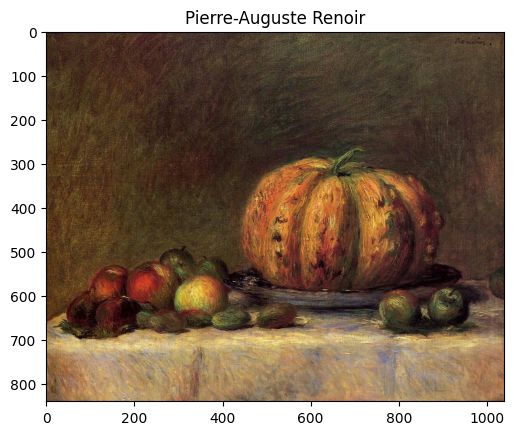

In [96]:
dataset = DataSet(file_path, train, train = True)

index = idx
plt.title(class_list[dataset[index]['class_id']])
plt.imshow(dataset[index]['image'])
plt.show()

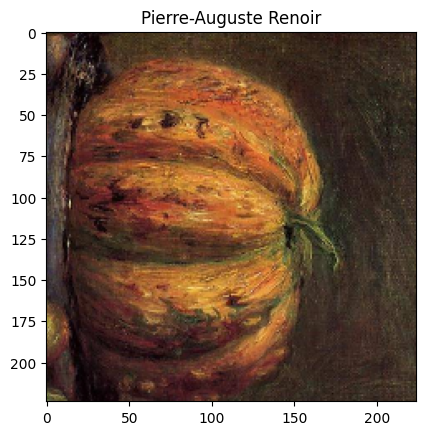

In [103]:
dataset = DataSet(file_path, train, train = True, transform = transformer)

index = idx
plt.title(class_list[dataset[index]['class_id']])
plt.imshow(dataset[index]['image'])
plt.show()